# Examples - DataFrame - Build Parallel Algorithms for Pandas
https://gist.github.com/mrocklin/d009e5d4a1f49ecdb433107f3d72c7f3#file-pygotham-dataframes-ipynb 

In [1]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

## prepare sample csv files

In [2]:
data_path = '../dask-tutorial/data/csv/'
dates = pd.date_range(start = '2015-1-1', end = '2015-2-28') 
timedeltas = pd.timedelta_range(start = 0, periods = 10, freq = '1H')
length = timedeltas.shape[0]

for date in dates:
    filename = str(date.date())
    file = os.path.join(data_path, filename)    
    
    df = DataFrame({'timestamp': date + timedeltas})
    df.index = df.timestamp
    df.index.name = 'index'
    df['value'] = np.random.randn(length)
    df['close'] = np.random.uniform(low = 10, high = 1000, size = length).round(2)
    df['high'] = np.random.uniform(low = 10, high = 1000, size = length).round(2)
    df['low'] = np.random.uniform(low = 10, high = 1000, size = length).round(2)
    df['open'] = np.random.uniform(low = 10, high = 1000, size = length).round(2)    
    
    df.to_csv(file + '.csv') 
    
df.tail()

,timestamp,value,close,high,low,open
index,,,,,,
2015-02-28 05:00:00,2015-02-28 05:00:00,-0.254489,788.61,585.87,277.05,477.57
2015-02-28 06:00:00,2015-02-28 06:00:00,1.085165,411.39,431.16,728.87,555.15
2015-02-28 07:00:00,2015-02-28 07:00:00,-0.794818,907.47,867.58,835.05,755.25
2015-02-28 08:00:00,2015-02-28 08:00:00,-0.624366,130.55,10.68,929.25,864.93
2015-02-28 09:00:00,2015-02-28 09:00:00,-0.198693,485.76,956.59,561.30,24.74


In [3]:
from glob import glob

filenames = sorted(glob(data_path + '2015-*.csv'))
filenames[:5]

['../dask-tutorial/data/csv/2015-01-01.csv',
 '../dask-tutorial/data/csv/2015-01-02.csv',
 '../dask-tutorial/data/csv/2015-01-03.csv',
 '../dask-tutorial/data/csv/2015-01-04.csv',
 '../dask-tutorial/data/csv/2015-01-05.csv']

In [4]:
len(filenames)

59

### Use Pandas on one file

In [5]:
df = pd.read_csv(filenames[0], parse_dates=['timestamp'], index_col=0)
df.tail()

,timestamp,value,close,high,low,open
index,,,,,,
2015-01-01 05:00:00,2015-01-01 05:00:00,0.332503,819.33,622.88,443.46,493.61
2015-01-01 06:00:00,2015-01-01 06:00:00,0.443744,29.20,245.18,501.18,365.43
2015-01-01 07:00:00,2015-01-01 07:00:00,-0.274386,411.33,559.88,229.64,663.58
2015-01-01 08:00:00,2015-01-01 08:00:00,0.365349,710.70,266.02,280.61,517.96
2015-01-01 09:00:00,2015-01-01 09:00:00,0.486758,652.62,106.79,285.23,403.35


In [6]:
df.close.mean()

535.6519999999999

In [7]:
df.groupby(df.timestamp.dt.hour).close.mean()

timestamp
0    324.98
1    305.43
2    423.69
3    732.04
4    947.20
5    819.33
6     29.20
7    411.33
8    710.70
9    652.62
Name: close, dtype: float64

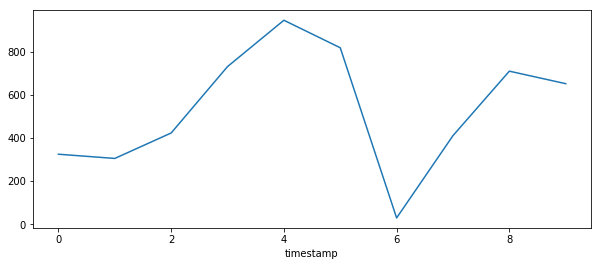

In [8]:
%matplotlib inline
df.groupby(df.timestamp.dt.hour).close.mean().plot(figsize=(10, 4));

### Dask.dataframe can do this on all of the csv files

In [9]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35845 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 8.28 GB


In [10]:
import dask.dataframe as dd 

df = dd.read_csv(data_path + '2015-*.csv', 
                 parse_dates=['timestamp']).set_index('index')
df.tail()

,timestamp,value,close,high,low,open
index,,,,,,
2015-02-28 05:00:00,2015-02-28 05:00:00,-0.254489,788.61,585.87,277.05,477.57
2015-02-28 06:00:00,2015-02-28 06:00:00,1.085165,411.39,431.16,728.87,555.15
2015-02-28 07:00:00,2015-02-28 07:00:00,-0.794818,907.47,867.58,835.05,755.25
2015-02-28 08:00:00,2015-02-28 08:00:00,-0.624366,130.55,10.68,929.25,864.93
2015-02-28 09:00:00,2015-02-28 09:00:00,-0.198693,485.76,956.59,561.30,24.74


In [11]:
df.close.mean().compute()

502.7854576271186

In [12]:
len(df)

590

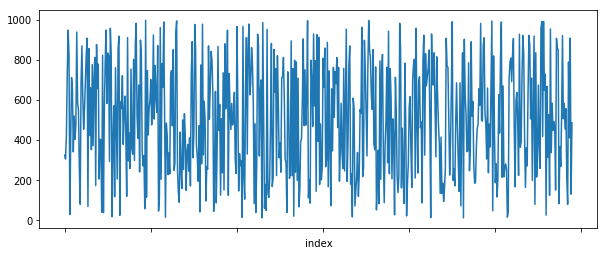

In [13]:
df.close.compute().plot(figsize=(10, 4));

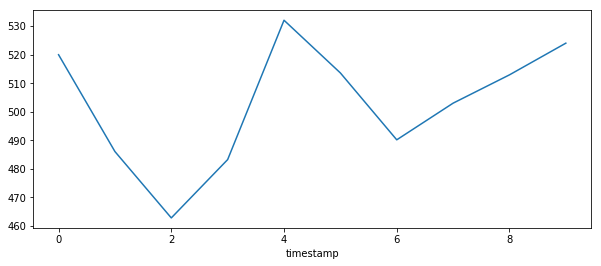

In [14]:
df.groupby(df.timestamp.dt.hour).close.mean().compute().plot(figsize=(10, 4));

### Use Pandas and a for loop on many CSV files

In [15]:
from dask import delayed

dfs = []

for fn in filenames:
    df = delayed(pd.read_csv)(fn, parse_dates=['timestamp'])
    dfs.append(df)
    
sums = []
counts = []

for df in dfs:
    sums.append(df.close.sum())
    counts.append(df.close.count())
    
result = delayed(sum)(sums) / delayed(sum)(counts)
result

Delayed('truediv-171d45e55260508a43de7be4dd5c7531')

### Parallelize with Dask.delayed

Only use the first ten filenames to produce a reasonable visualization

In [ ]:
result.visualize()

In [17]:
result.compute()

502.7854576271186

### These algorithms already exist in dask.dataframe

In [18]:
import dask.dataframe as dd 

df = dd.read_csv(data_path + '2015-*.csv', 
                 parse_dates=['timestamp']).set_index('index')
df.tail()
df

,timestamp,value,close,high,low,open
npartitions=59,,,,,,
2015-01-01 00:00:00,datetime64[ns],float64,float64,float64,float64,float64
2015-01-02 00:00:00,...,...,...,...,...,...
...,...,...,...,...,...,...
2015-02-28 00:00:00,...,...,...,...,...,...
2015-02-28 09:00:00,...,...,...,...,...,...


In [19]:
df.close.mean().compute()

502.7854576271186

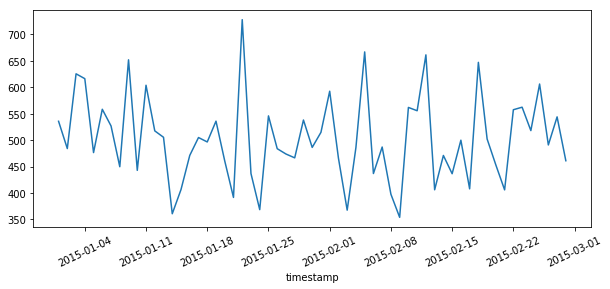

In [20]:
%matplotlib inline
result = (df.groupby(df.timestamp.dt.date)
            .close
            .mean()
            .compute()
            .plot(figsize=(10, 4), rot=25))

## Time Series

In [21]:
df = dd.read_csv(data_path + '2015-*.csv', 
                 parse_dates=['timestamp']).set_index('index')

df = client.persist(df.set_index(df.timestamp))
df

,timestamp,value,close,high,low,open
npartitions=59,,,,,,
2015-01-01 00:00:00,datetime64[ns],float64,float64,float64,float64,float64
2015-01-02 00:00:00,...,...,...,...,...,...
...,...,...,...,...,...,...
2015-02-28 00:00:00,...,...,...,...,...,...
2015-02-28 09:00:00,...,...,...,...,...,...


In [22]:
df.tail()

,timestamp,value,close,high,low,open
timestamp,,,,,,
2015-02-28 05:00:00,2015-02-28 05:00:00,-0.254489,788.61,585.87,277.05,477.57
2015-02-28 06:00:00,2015-02-28 06:00:00,1.085165,411.39,431.16,728.87,555.15
2015-02-28 07:00:00,2015-02-28 07:00:00,-0.794818,907.47,867.58,835.05,755.25
2015-02-28 08:00:00,2015-02-28 08:00:00,-0.624366,130.55,10.68,929.25,864.93
2015-02-28 09:00:00,2015-02-28 09:00:00,-0.198693,485.76,956.59,561.30,24.74


In [ ]:
(df.head(100, compute = False).close
   .rolling(10)
   .mean()
   .visualize(rankdir="LR"))

In [ ]:
(df.close
   .resample(rule=pd.Timedelta(hours=4)).count()
   .mean()
   .visualize(rankdir="LR"))

### Minimize Memory Use

In [25]:
dfs = []

for fn in filenames:
    dfs.append(pd.read_csv(fn, parse_dates=['timestamp']))
    
sums = []
counts = []

for df in dfs:
    sums.append(df.close.sum())
    counts.append(df.close.count())
    
sum(sums) / sum(counts)

502.7854576271186

In [26]:
sums = []
counts = []

for fn in filenames:
    df = pd.read_csv(fn, parse_dates=['timestamp'])
    sums.append(df.close.sum())
    counts.append(df.close.count())
    
sum(sums) / sum(counts)

502.7854576271186